In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
import random
%config InlineBackend.figure_format = 'retina'
DEVICE = "cuda" # or "cpu"
from tqdm.notebook import tqdm

# Load and normalize the FashionMNIST data

In [2]:
#Download the datasets
dataset_train = torchvision.datasets.FashionMNIST('../data', train=True, download=True,transform=torchvision.transforms.ToTensor())
dataset_test = torchvision.datasets.FashionMNIST('../data', train=False, download=True,transform=torchvision.transforms.ToTensor())
# For normalization, get mean and std of the training dataset
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=len(dataset_train))
data = next(iter(train_loader))[0]
mean, std = data.mean().item(), data.std().item()
print("Mean pixel is",mean," and std is",std)

# Now we can load the dataset with normalizing transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((mean,),(std,))
])
dataset_train.transform = transform
dataset_test.transform = transform

Mean pixel is 0.2860405743122101  and std is 0.3530242443084717


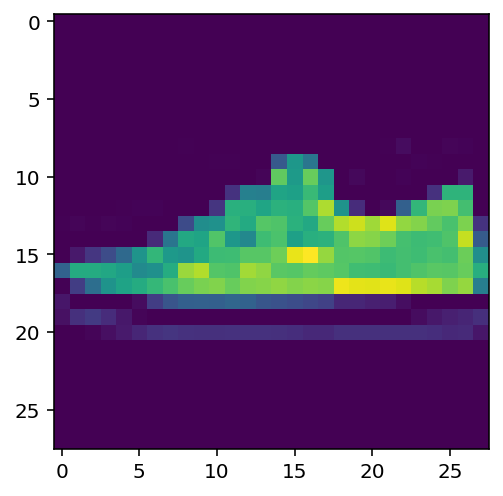

In [11]:
def showimg(tensor):
    plt.imshow(tensor.reshape(28,28))
showimg(dataset_train[13131][0]); # plt.imshow does a min-max normalization, so it always looks the same

# Generate the empirical graph with 2 clusters using the stochastic graph model

In [12]:
from graspologic.simulations import sbm

# Return the adjacency matrix (as numpy.ndarray), where elements are the link strengths
def getAfromSBM(n1=5, n2=5, p_in=0.5, p_out=0.1, mu_in=8, mu_out=2):
    n = [n1,n2]
    p = [[p_in, p_out], [p_out, p_in]]
    wt = [[np.random.normal,np.random.normal], [np.random.normal, np.random.normal]]
    wtargs = [[dict(loc=mu_in, scale=0), dict(loc=mu_out, scale=0)],
              [dict(loc=mu_out,scale=0), dict(loc=mu_in,  scale=0)]]
    A = sbm(n=n, p=p, wt=wt, wtargs=wtargs)
    return A

# For example
print(getAfromSBM(3,3,0.5,0.3,3,1))
# Note: A is always symmetric, has no self-loops

[[0. 3. 0. 1. 0. 0.]
 [3. 0. 3. 0. 1. 1.]
 [0. 3. 0. 0. 1. 0.]
 [1. 0. 0. 0. 3. 0.]
 [0. 1. 1. 3. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


# Define the model and divide + transform the MNIST data

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [14]:
# Custom class to apply the transformation only to the other half
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).
    
    Note that the data is not cloned/copied from the initial dataset"""
    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn
    
    def __getitem__(self, index):
        # Apply the given function (self.map) only to the feature, not the label
        return (self.map(self.dataset[index][0]), self.dataset[index][1])
    
    def __len__(self):
        return len(self.dataset)
    
def sizes(num,div):
    return [num // div + (1 if x < num % div else 0) for x in range(div)]

def rotation_transform(img):
    return torch.rot90(img,1,[-1,-2])

def initialize_learners(n_learners=10,n_training_data=60000):
    #n_learners = 10 # learners in the first cluster are 0,1,2,3,4; in the second cluster 5,6,7,8,9
    n1 = n_learners // 2
    n2 = n_learners - n1
    n1_list = range(n1)
    n2_list = range(n1,n2)
    # divide the data evenly to n_learners, apply rotation_transform to the second half of datasets
    dataset_sizes = sizes(n_training_data, n_learners) + [60000 - n_training_data]
    datasets = torch.utils.data.random_split(dataset_train,dataset_sizes)[:-1] # drop the last one, holding the unused data
    datasets = [dataset if n in n1_list else MapDataset(dataset, rotation_transform) for (n,dataset) in enumerate(datasets)]
    dataloaders = [torch.utils.data.DataLoader(datasets[i], batch_size = 256) for i in range(n_learners)]
    testloader = torch.utils.data.DataLoader(dataset_test, batch_size = 256)

    # Initialize the models
    models = [Net().to(DEVICE) for i in range(n_learners)]
    # Copy the initialization from model 0 to all others
    for i in range(1,n_learners):
        models[i].load_state_dict(models[0].state_dict())
    return dataloaders, testloader, models

def L2(local, neighbor):
    return torch.norm(local - neighbor)

def L2_squared(local, neighbor):
    #return torch.norm(local - neighbor).pow(2)
    return (local - neighbor).pow(2).sum()

def pi_1(tensor):
    mask = torch.cat([torch.ones(18816,device=DEVICE),torch.zeros(1181066,device=DEVICE)])
    return tensor * mask

def pi_2(tensor):
    mask = torch.cat([torch.zeros(18816,device=DEVICE),torch.ones(1181066,device=DEVICE)])
    return tensor * mask

def L2_early(local,neighbor):
    return torch.norm(pi_1(local)-pi_1(neighbor))

def L2_early_squared(local,neighbor):
    return torch.norm(pi_1(local)-pi_1(neighbor)).pow(2)

# Define the local learning step and testing procedure

In [15]:
# Takes a single optimizer step. Note that the optimizer state is updated.
def train_single_step(model, dataiter, optimizer, neighbor_thetas, neighbor_weights, lambd=0, g=L2_squared):
    model.train() # Change into training mode (matters for dropout, at least)
    data, target = next(dataiter)
    data, target = data.to(DEVICE), target.to(DEVICE)
    optimizer.zero_grad()
    # First, compute the local loss
    output = model(data)
    loss = F.nll_loss(output, target)
    # Then add the parameter differences
    local_theta = torch.nn.utils.parameters_to_vector(model.parameters())
    for i in range(len(neighbor_thetas)):
        loss += lambd * neighbor_weights[i] * g(local_theta, neighbor_thetas[i])
    loss.backward()
    optimizer.step()
    return loss.item()

In [16]:
def test(model, testloader, verbose=True):
    model.eval() #Change to evalution mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output=model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum of the batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item() # Number of correct guesses
    test_loss /= len(testloader.dataset) # Mean loss (divided by the size of the whole test set)
    
    if verbose: print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset), 100. * correct / len(testloader.dataset)))
    # Return both loss value and test accuracy
    return test_loss, correct / len(testloader.dataset)

In [17]:
def compute_L(models, dataloaders, A, lambd=0, g=L2_squared):
    L_loss = 0
    L_reg = 0
    with torch.no_grad():
        for i in range(len(models)):
            models[i].eval()
            loss, _ = test(models[i], dataloaders[i], verbose=False)
            L_loss += loss
            neighbor_indices = np.nonzero(A[i])[0]
            local_theta = torch.nn.utils.parameters_to_vector(models[i].parameters())
            for index in neighbor_indices:
                neighbor_theta = torch.nn.utils.parameters_to_vector(models[index].parameters()).detach()
                L_reg += 0.5 * lambd * A[i][index] * g(local_theta, neighbor_theta).item()
                # 0.5 because each edge is counted twice this way
    return L_loss, L_reg

def print_memory():
    print("Total:",torch.cuda.get_device_properties(0).total_memory)
    print("Allocated:",torch.cuda.memory_allocated(0))
    print("Reserved:",torch.cuda.memory_allocated(0))

# Define the optimization algorithm

In [18]:
def run_experiment(n_learners=10, n_iterations=10000, lambd=0.1, last_only=False, compute_L_flag=False,
                   p_in=1, p_out=1, verbose=False, g=L2_squared, n_training_data=60000):
    n1 = n_learners // 2
    n2 = n_learners - n1
    # Create a 2-cluster graph with all edges having weight 1
    A = getAfromSBM(n1, n2, p_in=p_in, p_out=p_out, mu_in=1, mu_out=1)
    
    dataloaders, testloader, models = initialize_learners(n_learners, n_training_data)
    
    # Create optimizers to hold the state of one model
    optimizers = [torch.optim.Adam(models[i].parameters()) for i in range(n_learners)]
    
    # Load batches infinitely in the same cycle (could update to resample a new loader after one epoch, but this is ok.)
    dataiters = [cycle(dataloader) for dataloader in dataloaders]
    
    results = []
    for i in tqdm(range(n_iterations)):
        # Choose a random learner (single one for now)
        k = random.randrange(n_learners)
        # Work out all the neighbors and the model states of the neighbors
        neighbor_indices = np.nonzero(A[k])[0]
        neighbor_weights = A[k][neighbor_indices]
        neighbor_thetas = []
        for index in neighbor_indices:
            neighbor_thetas.append(torch.nn.utils.parameters_to_vector(models[index].parameters()).detach())

        # Take the local step (except the first time)
        if i!= 0: train_single_step(models[k], dataiters[k], optimizers[k], neighbor_thetas, neighbor_weights, lambd,g=g)

        # At some timepoints, calculate losses and accuracies and add to results
        # If last_only is True, then only do this at the last timestep.
        if ((not last_only) and i % 100 == 0) or (last_only and i == n_iterations-1):
            if verbose: print("Iteration",i,":")
            train_loss, train_accuracy = test(models[0], dataloaders[0])
            # We measure the effectieness usin the first model, since it has learned to read images normally.
            test_loss, test_accuracy = test(models[0], testloader)
            if compute_L_flag:
                L_loss, L_reg = compute_L(models, dataloaders, A, lambd, g=g)
            else:
                L_loss, L_reg = 0, 0
            results.append((train_loss, train_accuracy, test_loss, test_accuracy,L_loss, L_reg))
    return results

# Run the experiment n=2 with lambda=1

In [11]:
results = run_experiment(2,5000,1, compute_L_flag=True)
train_losses = list(zip(*results))[0]
train_accuracies = list(zip(*results))[1]
test_losses = list(zip(*results))[2]
test_accuracies = list(zip(*results))[3]
L_losses = list(zip(*results))[4]
L_regs = list(zip(*results))[5]


Test set: Average loss: 2.2983, Accuracy: 3167/30000 (11%)


Test set: Average loss: 2.2985, Accuracy: 1034/10000 (10%)


Test set: Average loss: 0.6184, Accuracy: 23342/30000 (78%)


Test set: Average loss: 0.6393, Accuracy: 7685/10000 (77%)


Test set: Average loss: 0.4692, Accuracy: 24816/30000 (83%)


Test set: Average loss: 0.4985, Accuracy: 8131/10000 (81%)


Test set: Average loss: 0.4084, Accuracy: 25566/30000 (85%)


Test set: Average loss: 0.4416, Accuracy: 8401/10000 (84%)


Test set: Average loss: 0.3692, Accuracy: 26072/30000 (87%)


Test set: Average loss: 0.4084, Accuracy: 8534/10000 (85%)


Test set: Average loss: 0.3585, Accuracy: 26174/30000 (87%)


Test set: Average loss: 0.3995, Accuracy: 8583/10000 (86%)


Test set: Average loss: 0.3398, Accuracy: 26274/30000 (88%)


Test set: Average loss: 0.3815, Accuracy: 8615/10000 (86%)


Test set: Average loss: 0.3255, Accuracy: 26475/30000 (88%)


Test set: Average loss: 0.3684, Accuracy: 8680/10000 (87%)


Test set: Averag

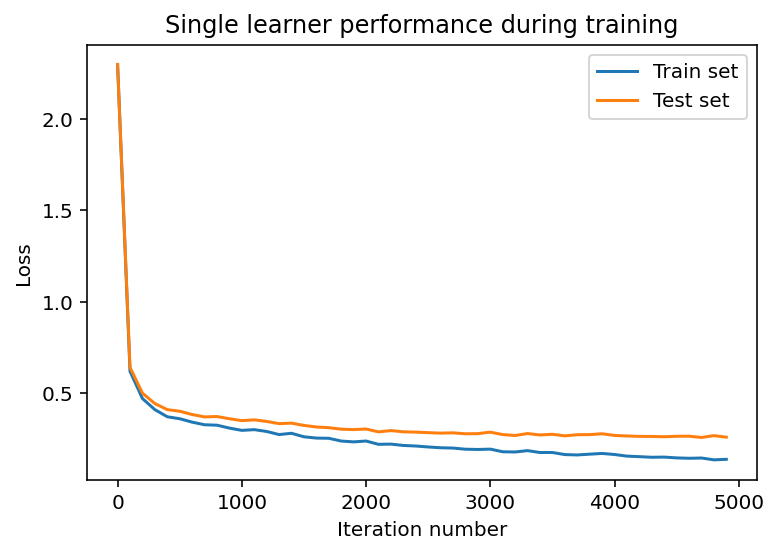

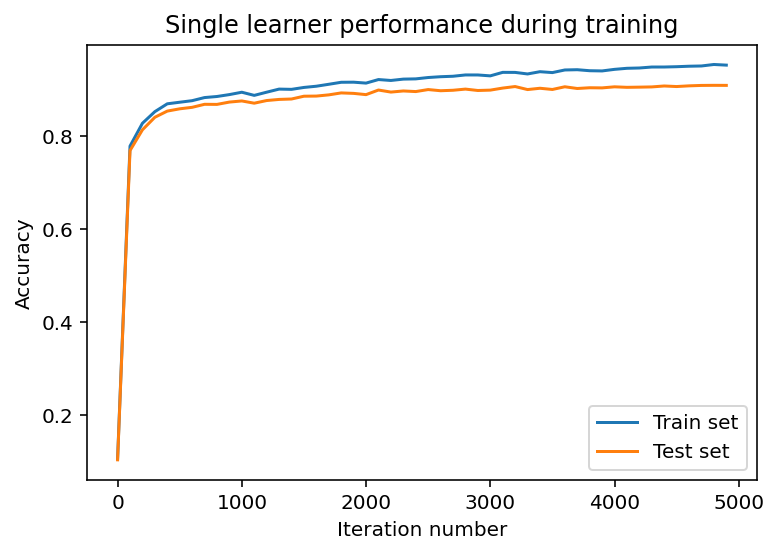

Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


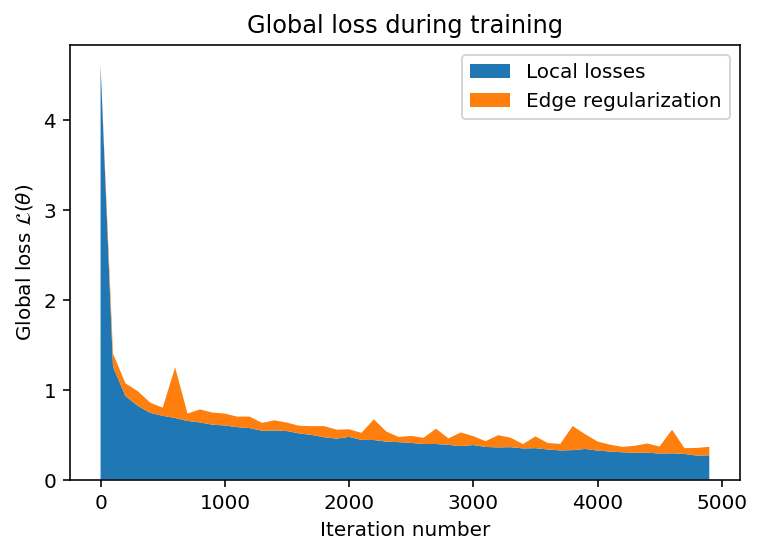

In [12]:
plt.figure()
plt.plot(range(0,100*len(train_losses),100),train_losses,label="Train set")
plt.plot(range(0,100*len(train_losses),100),test_losses,label="Test set")
plt.title("Single learner performance during training")
plt.xlabel("Iteration number")
plt.ylabel("Loss")
plt.legend()

plt.figure()
plt.plot(range(0,100*len(train_losses),100),train_accuracies,label="Train set")
plt.plot(range(0,100*len(train_losses),100),test_accuracies,label="Test set")
plt.title("Single learner performance during training")
plt.xlabel("Iteration number")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.stackplot(range(0,100*len(train_losses),100), L_losses, L_regs, labels=["Local losses", "Edge regularization"])
plt.title("Global loss during training")
plt.ylabel(r"Global loss $\mathcal{L}(\theta)$")
plt.xlabel("Iteration number")
plt.legend()

# Run the experiment with varying lambda

In [13]:
lambdas = np.logspace(-2,3,30) # From 0.001 to 100
results = []
for lambd in tqdm(lambdas):
    subresults = run_experiment(2, 10000, lambd, True)
    train_loss = list(zip(*subresults))[0][-1]
    train_accuracy = list(zip(*subresults))[1][-1]
    test_loss = list(zip(*subresults))[2][-1]
    test_accuracy = list(zip(*subresults))[3][-1]
    results.append((train_loss,train_accuracy,test_loss,test_accuracy))


Test set: Average loss: 0.0162, Accuracy: 29870/30000 (100%)


Test set: Average loss: 0.3343, Accuracy: 9176/10000 (92%)





Test set: Average loss: 0.0295, Accuracy: 29755/30000 (99%)


Test set: Average loss: 0.3374, Accuracy: 9122/10000 (91%)





Test set: Average loss: 0.0252, Accuracy: 29782/30000 (99%)


Test set: Average loss: 0.3216, Accuracy: 9177/10000 (92%)





Test set: Average loss: 0.0241, Accuracy: 29787/30000 (99%)


Test set: Average loss: 0.3218, Accuracy: 9172/10000 (92%)





Test set: Average loss: 0.0234, Accuracy: 29831/30000 (99%)


Test set: Average loss: 0.3041, Accuracy: 9198/10000 (92%)





Test set: Average loss: 0.0271, Accuracy: 29824/30000 (99%)


Test set: Average loss: 0.2953, Accuracy: 9181/10000 (92%)





Test set: Average loss: 0.0256, Accuracy: 29791/30000 (99%)


Test set: Average loss: 0.3230, Accuracy: 9165/10000 (92%)





Test set: Average loss: 0.0282, Accuracy: 29738/30000 (99%)


Test set: Average loss: 0.3031, Accuracy: 9166/10000 (92%)





Test set: Average loss: 0.0284, Accuracy: 29796/30000 (99%)


Test set: Average loss: 0.2876, Accuracy: 9188/10000 (92%)





Test set: Average loss: 0.0363, Accuracy: 29682/30000 (99%)


Test set: Average loss: 0.2896, Accuracy: 9162/10000 (92%)





Test set: Average loss: 0.0425, Accuracy: 29610/30000 (99%)


Test set: Average loss: 0.2997, Accuracy: 9107/10000 (91%)





Test set: Average loss: 0.0551, Accuracy: 29481/30000 (98%)


Test set: Average loss: 0.2724, Accuracy: 9164/10000 (92%)





Test set: Average loss: 0.0684, Accuracy: 29356/30000 (98%)


Test set: Average loss: 0.2740, Accuracy: 9111/10000 (91%)





Test set: Average loss: 0.0941, Accuracy: 28998/30000 (97%)


Test set: Average loss: 0.2647, Accuracy: 9121/10000 (91%)





Test set: Average loss: 0.1237, Accuracy: 28638/30000 (95%)


Test set: Average loss: 0.2618, Accuracy: 9100/10000 (91%)





Test set: Average loss: 0.1505, Accuracy: 28403/30000 (95%)


Test set: Average loss: 0.2641, Accuracy: 9044/10000 (90%)





Test set: Average loss: 0.1766, Accuracy: 28055/30000 (94%)


Test set: Average loss: 0.2687, Accuracy: 9025/10000 (90%)





Test set: Average loss: 0.2120, Accuracy: 27788/30000 (93%)


Test set: Average loss: 0.2768, Accuracy: 9003/10000 (90%)





Test set: Average loss: 0.2541, Accuracy: 27256/30000 (91%)


Test set: Average loss: 0.3083, Accuracy: 8890/10000 (89%)





Test set: Average loss: 0.3161, Accuracy: 26547/30000 (88%)


Test set: Average loss: 0.3607, Accuracy: 8714/10000 (87%)





Test set: Average loss: 0.3122, Accuracy: 26540/30000 (88%)


Test set: Average loss: 0.3586, Accuracy: 8687/10000 (87%)





Test set: Average loss: 0.3887, Accuracy: 25707/30000 (86%)


Test set: Average loss: 0.4314, Accuracy: 8444/10000 (84%)





Test set: Average loss: 0.4301, Accuracy: 25471/30000 (85%)


Test set: Average loss: 0.4652, Accuracy: 8330/10000 (83%)





Test set: Average loss: 0.5551, Accuracy: 23840/30000 (79%)


Test set: Average loss: 0.5746, Accuracy: 7905/10000 (79%)





Test set: Average loss: 0.5376, Accuracy: 23863/30000 (80%)


Test set: Average loss: 0.5588, Accuracy: 7905/10000 (79%)





Test set: Average loss: 0.5894, Accuracy: 23408/30000 (78%)


Test set: Average loss: 0.6128, Accuracy: 7707/10000 (77%)





Test set: Average loss: 0.8275, Accuracy: 21499/30000 (72%)


Test set: Average loss: 0.8396, Accuracy: 7057/10000 (71%)





Test set: Average loss: 0.6701, Accuracy: 22494/30000 (75%)


Test set: Average loss: 0.6943, Accuracy: 7424/10000 (74%)





Test set: Average loss: 0.8196, Accuracy: 21021/30000 (70%)


Test set: Average loss: 0.8362, Accuracy: 6918/10000 (69%)





Test set: Average loss: 0.8607, Accuracy: 20885/30000 (70%)


Test set: Average loss: 0.8761, Accuracy: 6873/10000 (69%)





In [14]:
train_losses = list(zip(*results))[0]
train_accuracies = list(zip(*results))[1]
test_losses = list(zip(*results))[2]
test_accuracies = list(zip(*results))[3]

The first accuracy is 0.9176
The best accuracy is 0.9198 , achieved by lambda= 0.04893900918477494


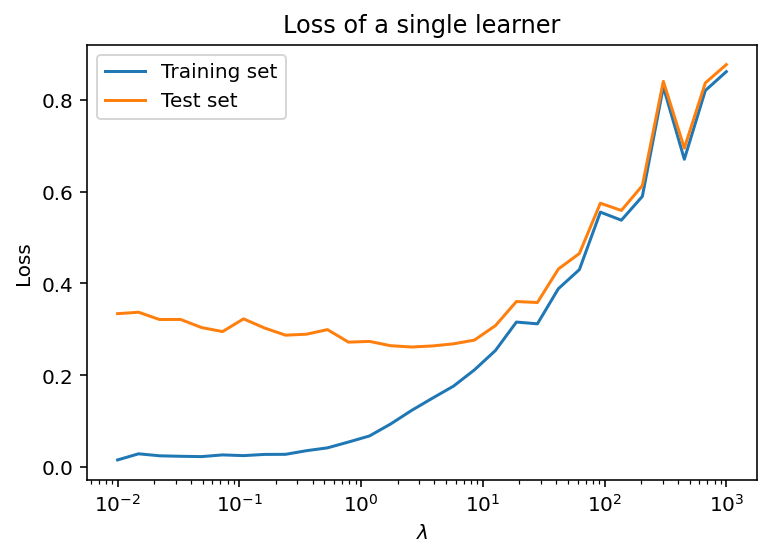

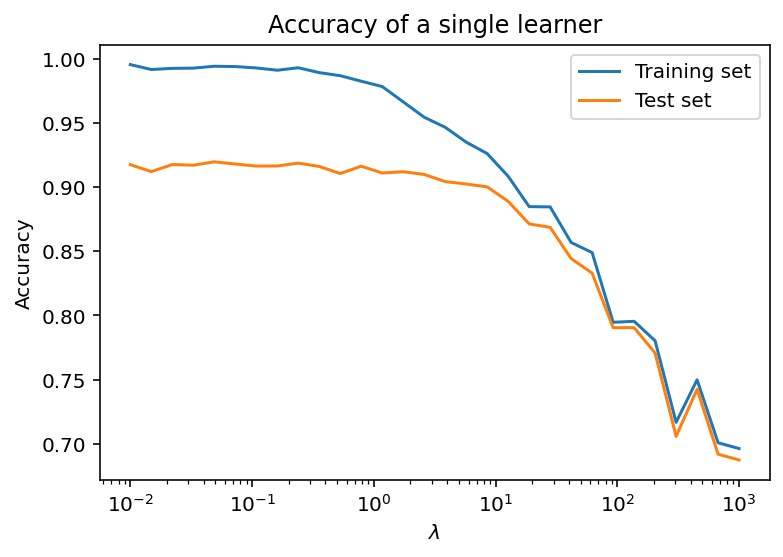

In [15]:
# 50 learners learning with ADAM and L2 norm for 5000 steps. The end state for a single learner.

plt.figure()
plt.plot(lambdas,train_losses, label="Training set")
plt.plot(lambdas,test_losses, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Loss of a single learner")
plt.ylabel("Loss")
plt.xlabel(r"$\lambda$")
plt.figure()
plt.plot(lambdas,train_accuracies, label="Training set")
plt.plot(lambdas,test_accuracies, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Accuracy of a single learner")
plt.ylabel("Accuracy")
plt.xlabel(r"$\lambda$");
print("The first accuracy is",test_accuracies[0])
print("The best accuracy is",np.max(test_accuracies),", achieved by lambda=",lambdas[np.argmax(test_accuracies)])

# Instead of full average, only share earlier layers

In [16]:
lambdas = np.logspace(-1,4,30) # From 0.001 to 100
results = []
for lambd in tqdm(lambdas):
    subresults = run_experiment(n_learners=2, n_iterations=10000, lambd=lambd, last_only=True, g=L2_early_squared)
    train_loss = list(zip(*subresults))[0][-1]
    train_accuracy = list(zip(*subresults))[1][-1]
    test_loss = list(zip(*subresults))[2][-1]
    test_accuracy = list(zip(*subresults))[3][-1]
    results.append((train_loss,train_accuracy,test_loss,test_accuracy))


Test set: Average loss: 0.0136, Accuracy: 29892/30000 (100%)


Test set: Average loss: 0.3800, Accuracy: 9172/10000 (92%)





Test set: Average loss: 0.0136, Accuracy: 29906/30000 (100%)


Test set: Average loss: 0.3660, Accuracy: 9184/10000 (92%)





Test set: Average loss: 0.0104, Accuracy: 29937/30000 (100%)


Test set: Average loss: 0.3807, Accuracy: 9172/10000 (92%)





Test set: Average loss: 0.0097, Accuracy: 29946/30000 (100%)


Test set: Average loss: 0.3551, Accuracy: 9169/10000 (92%)





Test set: Average loss: 0.0095, Accuracy: 29950/30000 (100%)


Test set: Average loss: 0.3671, Accuracy: 9197/10000 (92%)





Test set: Average loss: 0.0108, Accuracy: 29913/30000 (100%)


Test set: Average loss: 0.3639, Accuracy: 9181/10000 (92%)





Test set: Average loss: 0.0116, Accuracy: 29913/30000 (100%)


Test set: Average loss: 0.3734, Accuracy: 9196/10000 (92%)





Test set: Average loss: 0.0086, Accuracy: 29957/30000 (100%)


Test set: Average loss: 0.3841, Accuracy: 9182/10000 (92%)





Test set: Average loss: 0.0144, Accuracy: 29892/30000 (100%)


Test set: Average loss: 0.3531, Accuracy: 9185/10000 (92%)





Test set: Average loss: 0.0157, Accuracy: 29881/30000 (100%)


Test set: Average loss: 0.3641, Accuracy: 9145/10000 (91%)





Test set: Average loss: 0.0155, Accuracy: 29893/30000 (100%)


Test set: Average loss: 0.3420, Accuracy: 9172/10000 (92%)





Test set: Average loss: 0.0191, Accuracy: 29840/30000 (99%)


Test set: Average loss: 0.3459, Accuracy: 9185/10000 (92%)





Test set: Average loss: 0.0216, Accuracy: 29850/30000 (100%)


Test set: Average loss: 0.3239, Accuracy: 9171/10000 (92%)





Test set: Average loss: 0.0248, Accuracy: 29812/30000 (99%)


Test set: Average loss: 0.3259, Accuracy: 9163/10000 (92%)





Test set: Average loss: 0.0247, Accuracy: 29790/30000 (99%)


Test set: Average loss: 0.3360, Accuracy: 9201/10000 (92%)





Test set: Average loss: 0.0514, Accuracy: 29480/30000 (98%)


Test set: Average loss: 0.3301, Accuracy: 9089/10000 (91%)





Test set: Average loss: 0.0476, Accuracy: 29540/30000 (98%)


Test set: Average loss: 0.3166, Accuracy: 9118/10000 (91%)





Test set: Average loss: 0.0443, Accuracy: 29636/30000 (99%)


Test set: Average loss: 0.2944, Accuracy: 9158/10000 (92%)





Test set: Average loss: 0.1999, Accuracy: 27636/30000 (92%)


Test set: Average loss: 0.3318, Accuracy: 8889/10000 (89%)





Test set: Average loss: 0.1301, Accuracy: 28642/30000 (95%)


Test set: Average loss: 0.3001, Accuracy: 8979/10000 (90%)





Test set: Average loss: 0.1312, Accuracy: 28483/30000 (95%)


Test set: Average loss: 0.2983, Accuracy: 9003/10000 (90%)





Test set: Average loss: 0.0758, Accuracy: 29235/30000 (97%)


Test set: Average loss: 0.2937, Accuracy: 9104/10000 (91%)





Test set: Average loss: 0.1240, Accuracy: 28537/30000 (95%)


Test set: Average loss: 0.3097, Accuracy: 8985/10000 (90%)





Test set: Average loss: 0.2628, Accuracy: 26975/30000 (90%)


Test set: Average loss: 0.3383, Accuracy: 8802/10000 (88%)





Test set: Average loss: 0.2667, Accuracy: 27056/30000 (90%)


Test set: Average loss: 0.3467, Accuracy: 8756/10000 (88%)





Test set: Average loss: 0.2243, Accuracy: 27466/30000 (92%)


Test set: Average loss: 0.3244, Accuracy: 8910/10000 (89%)





Test set: Average loss: 0.3408, Accuracy: 26134/30000 (87%)


Test set: Average loss: 0.4007, Accuracy: 8526/10000 (85%)





Test set: Average loss: 0.2236, Accuracy: 27432/30000 (91%)


Test set: Average loss: 0.3256, Accuracy: 8846/10000 (88%)





Test set: Average loss: 0.2696, Accuracy: 26951/30000 (90%)


Test set: Average loss: 0.3546, Accuracy: 8728/10000 (87%)





Test set: Average loss: 0.2022, Accuracy: 27686/30000 (92%)


Test set: Average loss: 0.3247, Accuracy: 8875/10000 (89%)





In [17]:
train_losses = list(zip(*results))[0]
train_accuracies = list(zip(*results))[1]
test_losses = list(zip(*results))[2]
test_accuracies = list(zip(*results))[3]

The first accuracy is 0.9172
The best accuracy is 0.9201 , achieved by lambda= 25.92943797404667


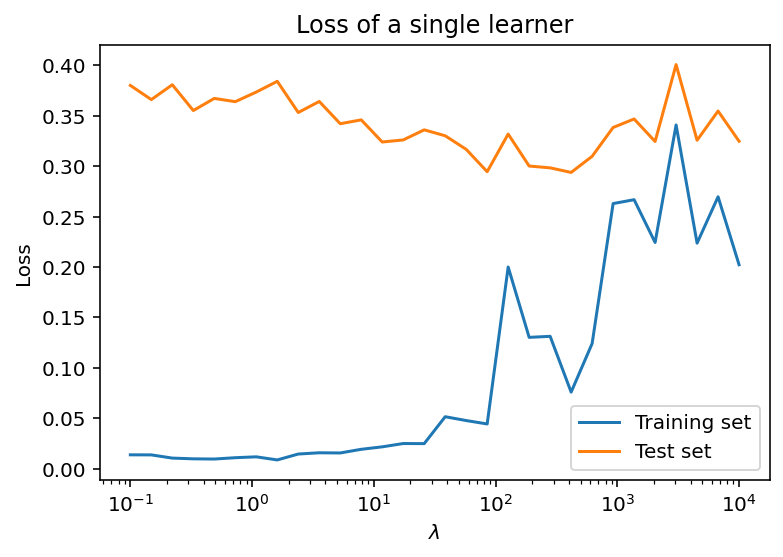

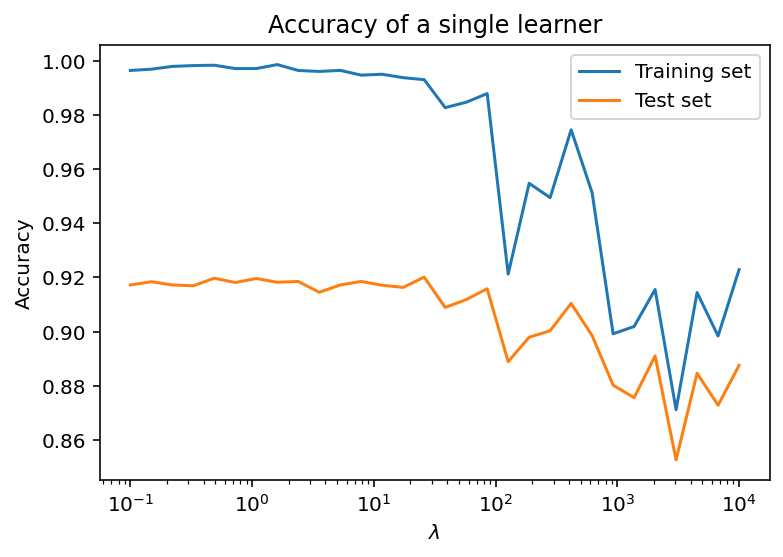

In [18]:
# 50 learners learning with ADAM and L2 norm for 5000 steps. The end state for a single learner.

plt.figure()
plt.plot(lambdas,train_losses, label="Training set")
plt.plot(lambdas,test_losses, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Loss of a single learner")
plt.ylabel("Loss")
plt.xlabel(r"$\lambda$")
plt.figure()
plt.plot(lambdas,train_accuracies, label="Training set")
plt.plot(lambdas,test_accuracies, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Accuracy of a single learner")
plt.ylabel("Accuracy")
plt.xlabel(r"$\lambda$");
print("The first accuracy is",test_accuracies[0])
print("The best accuracy is",np.max(test_accuracies),", achieved by lambda=",lambdas[np.argmax(test_accuracies)])

# 2 learners, with less data available and early sharing only

In [19]:
lambdas = np.logspace(-2,4,30) # From 0.001 to 100
results = []
for lambd in tqdm(lambdas):
    subresults = run_experiment(n_learners=2, n_iterations=10000, lambd=lambd, last_only=True, g=L2_early_squared, n_training_data=2000)
    train_loss = list(zip(*subresults))[0][-1]
    train_accuracy = list(zip(*subresults))[1][-1]
    test_loss = list(zip(*subresults))[2][-1]
    test_accuracy = list(zip(*subresults))[3][-1]
    results.append((train_loss,train_accuracy,test_loss,test_accuracy))


Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 2.0681, Accuracy: 8324/10000 (83%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 2.1020, Accuracy: 8377/10000 (84%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 2.0233, Accuracy: 8363/10000 (84%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.9722, Accuracy: 8300/10000 (83%)





Test set: Average loss: 0.0004, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.9528, Accuracy: 8288/10000 (83%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.8452, Accuracy: 8399/10000 (84%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.9864, Accuracy: 8284/10000 (83%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.8785, Accuracy: 8389/10000 (84%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 2.2941, Accuracy: 8302/10000 (83%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.8640, Accuracy: 8338/10000 (83%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.8162, Accuracy: 8221/10000 (82%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.9800, Accuracy: 8236/10000 (82%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 2.2265, Accuracy: 8299/10000 (83%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 2.0125, Accuracy: 8261/10000 (83%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 2.1821, Accuracy: 8248/10000 (82%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 2.3696, Accuracy: 8247/10000 (82%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.9818, Accuracy: 8232/10000 (82%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.8473, Accuracy: 8328/10000 (83%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.9037, Accuracy: 8219/10000 (82%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.7947, Accuracy: 8278/10000 (83%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.9350, Accuracy: 8314/10000 (83%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.7725, Accuracy: 8203/10000 (82%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.8118, Accuracy: 8232/10000 (82%)





Test set: Average loss: 0.0009, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.8365, Accuracy: 8168/10000 (82%)





Test set: Average loss: 0.0004, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.6738, Accuracy: 8245/10000 (82%)





Test set: Average loss: 0.0014, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.4540, Accuracy: 8206/10000 (82%)





Test set: Average loss: 0.0059, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.1615, Accuracy: 8211/10000 (82%)





Test set: Average loss: 0.0041, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.2766, Accuracy: 8189/10000 (82%)





Test set: Average loss: 0.0006, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.5024, Accuracy: 8256/10000 (83%)





Test set: Average loss: 0.0676, Accuracy: 978/1000 (98%)


Test set: Average loss: 0.9870, Accuracy: 7893/10000 (79%)





In [20]:
train_losses = list(zip(*results))[0]
train_accuracies = list(zip(*results))[1]
test_losses = list(zip(*results))[2]
test_accuracies = list(zip(*results))[3]

The first accuracy is 0.8324
The best accuracy is 0.8399 , achieved by lambda= 0.10826367338740546


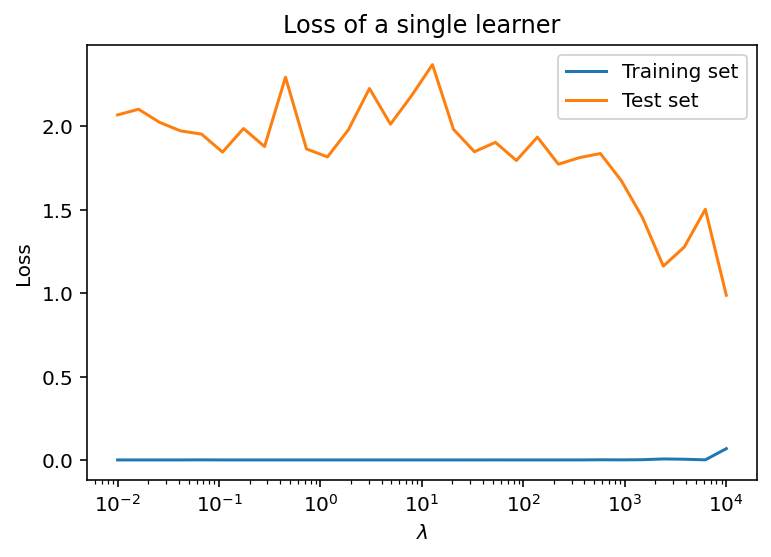

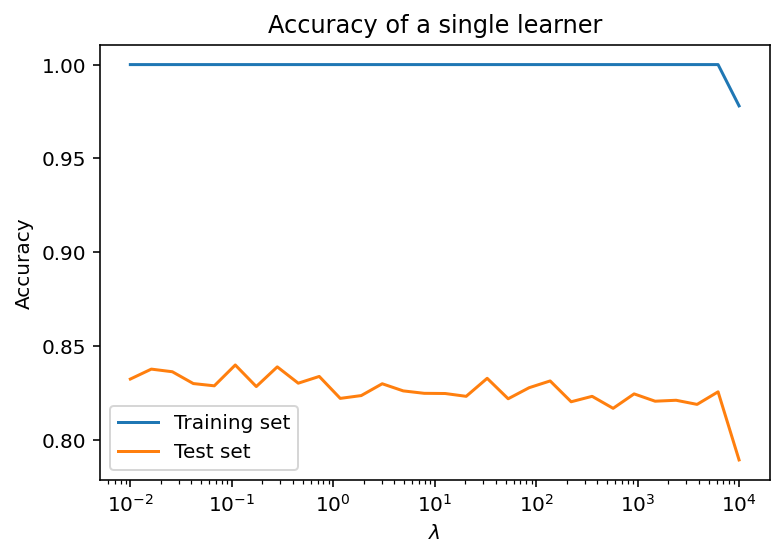

In [21]:
# 2 learners learning with ADAM and L2 norm for 10000 steps. The data in use is 1000 images for both.

plt.figure()
plt.plot(lambdas,train_losses, label="Training set")
plt.plot(lambdas,test_losses, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Loss of a single learner")
plt.ylabel("Loss")
plt.xlabel(r"$\lambda$")
plt.figure()
plt.plot(lambdas,train_accuracies, label="Training set")
plt.plot(lambdas,test_accuracies, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Accuracy of a single learner")
plt.ylabel("Accuracy")
plt.xlabel(r"$\lambda$");
print("The first accuracy is",test_accuracies[0])
print("The best accuracy is",np.max(test_accuracies),", achieved by lambda=",lambdas[np.argmax(test_accuracies)])

# Sharing of all but the last layer, less data

In [23]:
def pi_3(tensor):
    mask = torch.cat([torch.ones(1198592,device=DEVICE),torch.zeros(1290,device=DEVICE)])
    return tensor * mask

# Squared euclidian distance of all but the last layer
def L2_semiearly_squared(local,neighbor):
    return torch.norm(pi_3(local)-pi_3(neighbor)).pow(2)

In [24]:
lambdas = np.logspace(-2,4,30) # From 0.001 to 100
results = []
for lambd in tqdm(lambdas):
    subresults = run_experiment(n_learners=2, n_iterations=3000, lambd=lambd, last_only=True, g=L2_semiearly_squared, n_training_data=2000)
    train_loss = list(zip(*subresults))[0][-1]
    train_accuracy = list(zip(*subresults))[1][-1]
    test_loss = list(zip(*subresults))[2][-1]
    test_accuracy = list(zip(*subresults))[3][-1]
    results.append((train_loss,train_accuracy,test_loss,test_accuracy))


Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.3166, Accuracy: 8288/10000 (83%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.4994, Accuracy: 8219/10000 (82%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.3346, Accuracy: 8249/10000 (82%)





Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.3789, Accuracy: 8373/10000 (84%)





Test set: Average loss: 0.0001, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.4425, Accuracy: 8258/10000 (83%)





Test set: Average loss: 0.0001, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.3347, Accuracy: 8171/10000 (82%)





Test set: Average loss: 0.0003, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.3870, Accuracy: 8211/10000 (82%)





Test set: Average loss: 0.0002, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.2555, Accuracy: 8298/10000 (83%)





Test set: Average loss: 0.0002, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.2266, Accuracy: 8274/10000 (83%)





Test set: Average loss: 0.0003, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.1918, Accuracy: 8336/10000 (83%)





Test set: Average loss: 0.0002, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.2974, Accuracy: 8267/10000 (83%)





Test set: Average loss: 0.0007, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.2192, Accuracy: 8316/10000 (83%)





Test set: Average loss: 0.0013, Accuracy: 1000/1000 (100%)


Test set: Average loss: 1.0261, Accuracy: 8358/10000 (84%)





Test set: Average loss: 0.0107, Accuracy: 998/1000 (100%)


Test set: Average loss: 1.0106, Accuracy: 8211/10000 (82%)





Test set: Average loss: 0.0152, Accuracy: 996/1000 (100%)


Test set: Average loss: 0.9770, Accuracy: 8209/10000 (82%)





Test set: Average loss: 0.0205, Accuracy: 998/1000 (100%)


Test set: Average loss: 0.7048, Accuracy: 8303/10000 (83%)





Test set: Average loss: 0.1097, Accuracy: 966/1000 (97%)


Test set: Average loss: 0.6081, Accuracy: 8092/10000 (81%)





Test set: Average loss: 0.0914, Accuracy: 977/1000 (98%)


Test set: Average loss: 0.6368, Accuracy: 8171/10000 (82%)





Test set: Average loss: 0.2346, Accuracy: 922/1000 (92%)


Test set: Average loss: 0.6530, Accuracy: 7922/10000 (79%)





Test set: Average loss: 0.3001, Accuracy: 884/1000 (88%)


Test set: Average loss: 0.5814, Accuracy: 7953/10000 (80%)





Test set: Average loss: 0.3781, Accuracy: 847/1000 (85%)


Test set: Average loss: 0.5879, Accuracy: 7776/10000 (78%)





Test set: Average loss: 0.6387, Accuracy: 751/1000 (75%)


Test set: Average loss: 0.7799, Accuracy: 7397/10000 (74%)





Test set: Average loss: 0.5243, Accuracy: 817/1000 (82%)


Test set: Average loss: 0.6560, Accuracy: 7644/10000 (76%)





Test set: Average loss: 0.9337, Accuracy: 659/1000 (66%)


Test set: Average loss: 0.9522, Accuracy: 6611/10000 (66%)





Test set: Average loss: 0.8135, Accuracy: 696/1000 (70%)


Test set: Average loss: 0.8956, Accuracy: 6768/10000 (68%)





Test set: Average loss: 0.8878, Accuracy: 699/1000 (70%)


Test set: Average loss: 0.8991, Accuracy: 6771/10000 (68%)





Test set: Average loss: 0.8429, Accuracy: 698/1000 (70%)


Test set: Average loss: 0.9206, Accuracy: 6675/10000 (67%)





Test set: Average loss: 0.8577, Accuracy: 707/1000 (71%)


Test set: Average loss: 0.8986, Accuracy: 6748/10000 (67%)





Test set: Average loss: 1.0439, Accuracy: 659/1000 (66%)


Test set: Average loss: 1.0576, Accuracy: 6568/10000 (66%)





Test set: Average loss: 1.0780, Accuracy: 669/1000 (67%)


Test set: Average loss: 1.1008, Accuracy: 6517/10000 (65%)





In [25]:
train_losses = list(zip(*results))[0]
train_accuracies = list(zip(*results))[1]
test_losses = list(zip(*results))[2]
test_accuracies = list(zip(*results))[3]

The first accuracy is 0.8288
The best accuracy is 0.8373 , achieved by lambda= 0.041753189365604


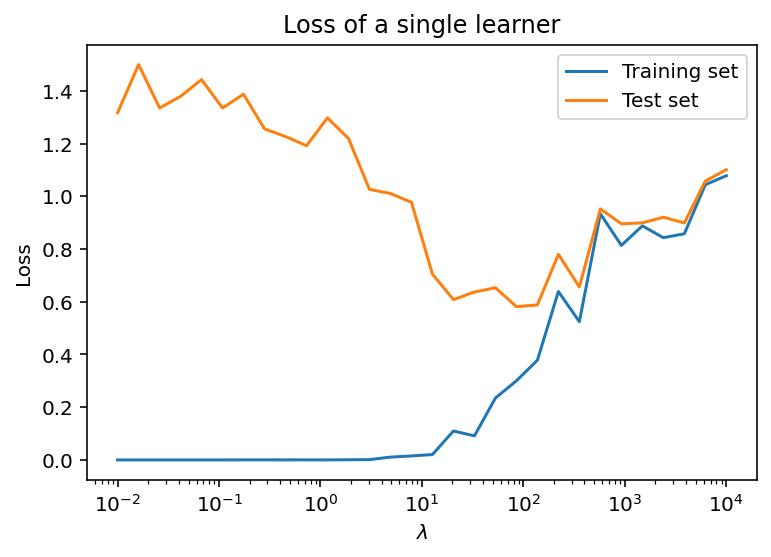

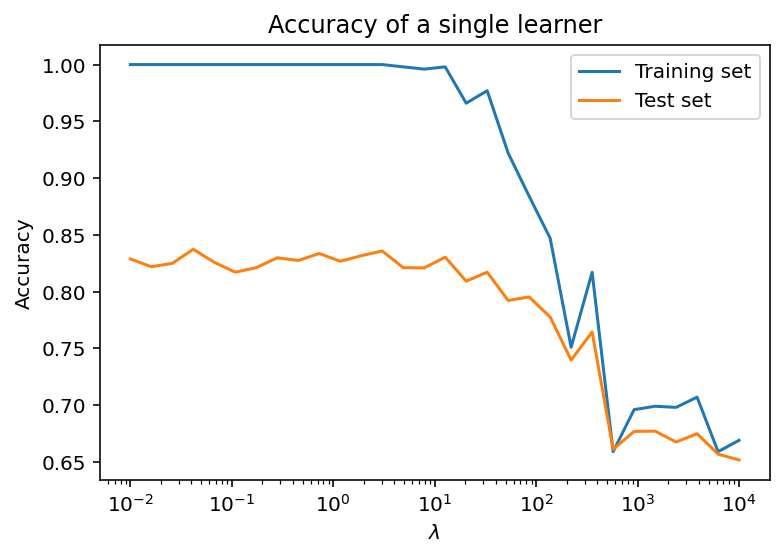

In [26]:
# 2 learners learning with ADAM and L2_squared_semiearly norm for 3000 steps. The data in use is 1000 images for both.

plt.figure()
plt.plot(lambdas,train_losses, label="Training set")
plt.plot(lambdas,test_losses, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Loss of a single learner")
plt.ylabel("Loss")
plt.xlabel(r"$\lambda$")
plt.figure()
plt.plot(lambdas,train_accuracies, label="Training set")
plt.plot(lambdas,test_accuracies, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Accuracy of a single learner")
plt.ylabel("Accuracy")
plt.xlabel(r"$\lambda$");
print("The first accuracy is",test_accuracies[0])
print("The best accuracy is",np.max(test_accuracies),", achieved by lambda=",lambdas[np.argmax(test_accuracies)])

# Run the same thing with 2 clusters

In [26]:
lambdas = np.logspace(-3,3,30) # From 0.001 to 100
results = []
for lambd in tqdm(lambdas):
    subresults = run_experiment(n_learners=60, n_iterations=10000, lambd=lambd, last_only=True, g=L2_early, p_in=0.5, p_out=0.1)
    train_loss = list(zip(*subresults))[0][-1]
    train_accuracy = list(zip(*subresults))[1][-1]
    test_loss = list(zip(*subresults))[2][-1]
    test_accuracy = list(zip(*subresults))[3][-1]
    results.append((train_loss,train_accuracy,test_loss,test_accuracy))

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 1.37 GiB already allocated; 16.73 MiB free; 1.49 GiB reserved in total by PyTorch)

In [15]:
train_losses = list(zip(*results))[0]
train_accuracies = list(zip(*results))[1]
test_losses = list(zip(*results))[2]
test_accuracies = list(zip(*results))[3]

The first accuracy is 0.9504
The best accuracy is 0.9504 , achieved by lambda= 0.001


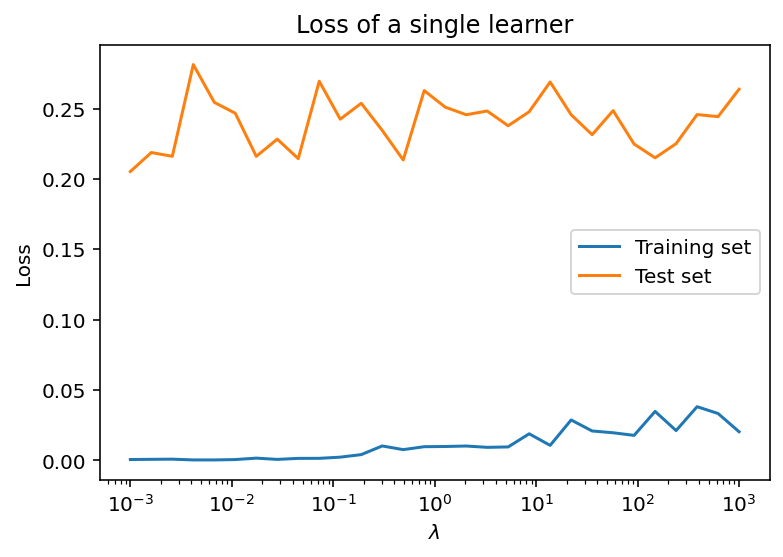

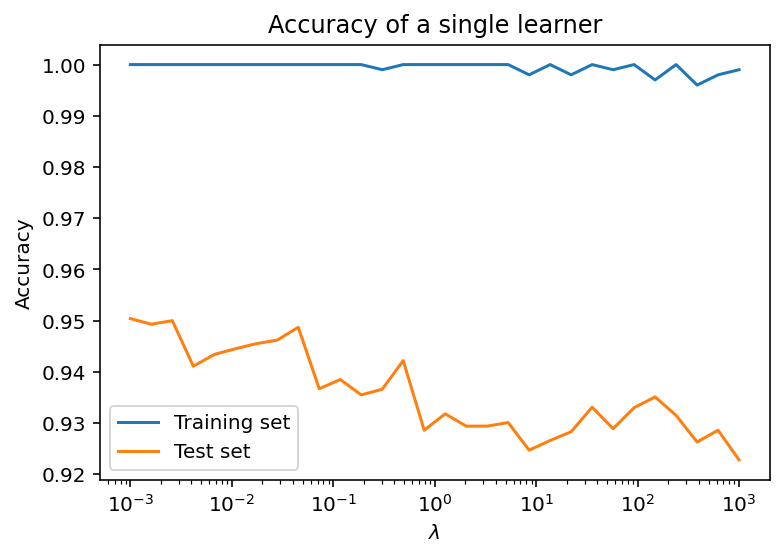

In [16]:
# 2 learners learning with ADAM and L2 norm for 10000 steps. The data in use is 1000 images for both.

plt.figure()
plt.plot(lambdas,train_losses, label="Training set")
plt.plot(lambdas,test_losses, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Loss of a single learner")
plt.ylabel("Loss")
plt.xlabel(r"$\lambda$")
plt.figure()
plt.plot(lambdas,train_accuracies, label="Training set")
plt.plot(lambdas,test_accuracies, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Accuracy of a single learner")
plt.ylabel("Accuracy")
plt.xlabel(r"$\lambda$");
print("The first accuracy is",test_accuracies[0])
print("The best accuracy is",np.max(test_accuracies),", achieved by lambda=",lambdas[np.argmax(test_accuracies)])